In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from feature_engine.imputation import ArbitraryNumberImputer,CategoricalImputer
from feature_engine.encoding import RareLabelEncoder,OrdinalEncoder

data=pd.read_csv("titanic.csv",usecols=["Pclass","Sex","Age","SibSp","Parch","Fare","Cabin","Embarked","Survived"])
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,NaN,S
887,1,1,female,19.0,0,0,30.0000,B42,S
888,0,3,female,NaN,1,2,23.4500,NaN,S
889,1,1,male,26.0,0,0,30.0000,C148,C


In [3]:
data["Cabin_num"] = data["Cabin"].str.extract('(\d+)')
data["Cabin_num"] = data["Cabin_num"].astype(float)
data["Cabin_cat"] = data["Cabin"].str[0]
data.drop("Cabin",axis=1,inplace=True)

In [14]:
data[cat_cols]

,Sex,Embarked,Cabin_cat,Pclass,SibSp,Parch
0,male,S,NaN,3,1,0
1,female,C,C,1,1,0
2,female,S,NaN,3,0,0
3,female,S,C,1,1,0
4,male,S,NaN,3,0,0
...,...,...,...,...,...,...
886,male,S,NaN,2,0,0
887,female,S,B,1,0,0
888,female,S,NaN,3,1,2
889,male,C,C,1,0,0


In [15]:
data[num_cols]

,Age,Fare,Cabin_num
0,22.0,7.2500,NaN
1,38.0,71.2833,85.0
2,26.0,7.9250,NaN
3,35.0,53.1000,123.0
4,35.0,8.0500,NaN
...,...,...,...
886,27.0,13.0000,NaN
887,19.0,30.0000,42.0
888,NaN,23.4500,NaN
889,26.0,30.0000,148.0


In [16]:
data[num_but_cat]

,Pclass,SibSp,Parch
0,3,1,0
1,1,1,0
2,3,0,0
3,1,1,0
4,3,0,0
...,...,...,...
886,2,0,0
887,1,0,0
888,3,1,2
889,1,0,0


In [5]:
X=data.drop("Survived",axis=1)
y=data["Survived"]

cat_cols = list(X.select_dtypes(exclude="number"))
num_cols = list(X.select_dtypes(include="number"))

num_but_cat = [col for col in num_cols if X[col].nunique()<20]
cat_cols = cat_cols + num_but_cat
num_cols = [col for col in num_cols if col not in num_but_cat]


cat_but_car = [col for col in cat_cols if X[col].nunique()>15]
X[num_but_cat] = X[num_but_cat].astype("O")

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=10,stratify=y)
X_train.shape, X_test.shape

((801, 9), (90, 9))

In [8]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_num,Cabin_cat
0,3,male,22.0,1,0,7.2500,S,NaN,NaN
1,1,female,38.0,1,0,71.2833,C,85.0,C
2,3,female,26.0,0,0,7.9250,S,NaN,NaN
3,1,female,35.0,1,0,53.1000,S,123.0,C
4,3,male,35.0,0,0,8.0500,S,NaN,NaN


In [11]:
titanic_pipe = Pipeline([
    
    ("imputer_num",ArbitraryNumberImputer(arbitrary_number=-1,variables=num_cols)),
    ("imputer_cat",CategoricalImputer(variables=["Embarked","Cabin_cat"])),
    ("rare_encoder",RareLabelEncoder(tol=0.01,n_categories=1,variables=cat_cols)),
    ("cat_encoder",OrdinalEncoder(encoding_method="ordered",variables=cat_cols)),
    
    ("gbm",GradientBoostingClassifier(random_state=10))
    
])

In [12]:
titanic_pipe.fit(X_train,y_train)

Pipeline(steps=[('imputer_num',
                 ArbitraryNumberImputer(arbitrary_number=-1,
                                        variables=['Age', 'Fare',
                                                   'Cabin_num'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['Embarked', 'Cabin_cat'])),
                ('rare_encoder',
                 RareLabelEncoder(n_categories=1, tol=0.01,
                                  variables=['Sex', 'Embarked', 'Cabin_cat',
                                             'Pclass', 'SibSp', 'Parch'])),
                ('cat_encoder',
                 OrdinalEncoder(variables=['Sex', 'Embarked', 'Cabin_cat',
                                           'Pclass', 'SibSp', 'Parch'])),
                ('gbm', GradientBoostingClassifier(random_state=10))])

In [13]:
param_grid = {
    'imputer_num__arbitrary_number':[-1,99],
    'rare_encoder__tol':[0.05,0.1,0.15],
    'cat_encoder__encoding_method':["ordered","arbitrary"],
    'gbm__max_depth':[None,3,4,5]
}

grid_search = GridSearchCV(titanic_pipe,param_grid,cv=10,n_jobs=-1,scoring="roc_auc")
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('imputer_num',
                                        ArbitraryNumberImputer(arbitrary_number=-1,
                                                               variables=['Age',
                                                                          'Fare',
                                                                          'Cabin_num'])),
                                       ('imputer_cat',
                                        CategoricalImputer(variables=['Embarked',
                                                                      'Cabin_cat'])),
                                       ('rare_encoder',
                                        RareLabelEncoder(n_categories=1,
                                                         tol=0.01,
                                                         variables=['Sex',
                                                                    'Embarked',
                                                                    'Cabin_cat',
                                                                    'Pclass',
                                                                    'SibSp',
                                                                    'Parch'])),
                                       ('cat_encoder',
                                        OrdinalEncoder(variables=['Sex',
                                                                  'Embarked',
                                                                  'Cabin_cat',
                                                                  'Pclass',
                                                                  'SibSp',
                                                                  'Parch'])),
                                       ('gbm',
                                        GradientBoostingClassifier(random_state=10))]),
             n_jobs=-1,
             param_grid={'cat_encoder__encoding_method': ['ordered',
                                                          'arbitrary'],
                         'gbm__max_depth': [None, 3, 4, 5],
                         'imputer_num__arbitrary_number': [-1, 99],
                         'rare_encoder__tol': [0.05, 0.1, 0.15]},
             scoring='roc_auc')

In [17]:
grid_search.best_params_

{'cat_encoder__encoding_method': 'ordered',
 'gbm__max_depth': 3,
 'imputer_num__arbitrary_number': 99,
 'rare_encoder__tol': 0.15}

<Axes: >

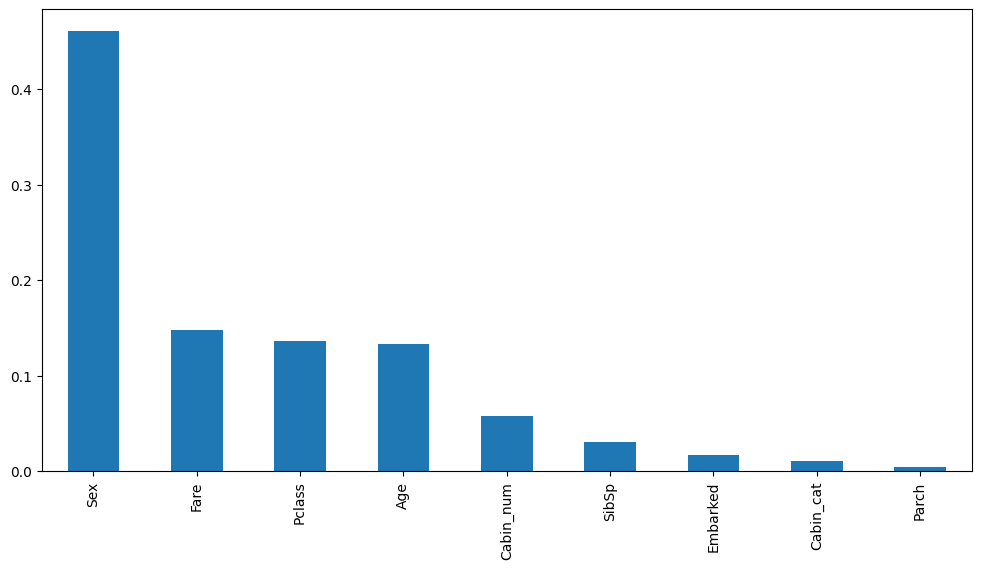

In [18]:
importance = pd.Series(grid_search.best_estimator_["gbm"].feature_importances_,index=X_train.columns)
importance.sort_values(ascending=False,inplace=True)
importance.plot.bar(figsize=(12,6))